# Let's replace the nn model with a parameterised quantum circuit

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

# from data import harmonic_oscillator_solution
# from lossfn import mse, boundary_loss, physics_loss, physics_loss_imp
# from model import Hybrid_QN
# from utils import draw_circuit

import pennylane as qml

from IPython.display import clear_output

import copy

In [2]:
torch.manual_seed(123)
n_qubits = 6
n_layers = 5
n_input = 1
n_output = 1


# DATA USED

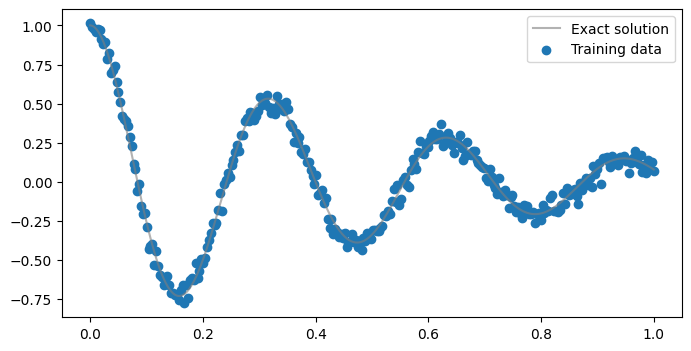

In [3]:
def harmonic_oscillator_solution(d, w0, t):

    ''' Analytical solution to a under-damped harmonic oscillator, I am just going to use the solution given above
    - d - delta, the damping ratio,
    - w0 - undamped angular frequency,
    - t - time,
    '''

    assert d < w0 # check for undamped case
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    x = exp*2*A*cos
    
    return x

# Full dataset
data = pd.read_csv('./time-oscillation.csv', dtype=np.float32)

d, w0 = 2, 20
t_true = torch.linspace(0,1,500).view(-1,1)
obs_true = harmonic_oscillator_solution(d, w0, t_true)

t_data = torch.tensor(data['t'].values).view(-1,1)
obs_data = torch.tensor(data['observation'].values).view(-1,1)

plt.figure(figsize=(8,4))
plt.plot(t_true, obs_true, color="tab:grey", alpha=0.6, label="Exact solution")
plt.scatter(t_data, obs_data, label="Training data")
plt.legend()
plt.show()

For simplicity, we only get 16% of data for training, as below:

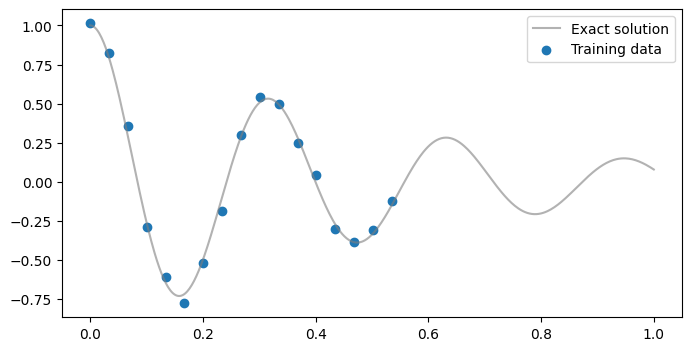

In [4]:
total = 100
percentage = 55

d, w0 = 2, 20
t_true = torch.linspace(0,1,500).view(-1,1)[:int(np.ceil(total/100*500))]
obs_true = harmonic_oscillator_solution(d, w0, t_true)

t_data = torch.tensor(data['t'].values)[:int(np.ceil(percentage/100*len(data)))][::10].view(-1,1)
obs_data = torch.tensor(data['observation'].values)[:int(np.ceil(percentage/100*len(data)))][::10].view(-1,1)

plt.figure(figsize=(8,4))
plt.plot(t_true, obs_true, color="tab:grey", alpha=0.6, label="Exact solution")
plt.scatter(t_data, obs_data, label="Training data")
plt.legend()
plt.show()

# Model and Loss functions

Please don't mind this lengthy code block

In [5]:
### Data params
n_data = 4
x_angle_margin = 0.1
x_angle_min = 0+x_angle_margin
x_angle_max =np.pi-x_angle_margin

### Architectural params
n_wires = n_data
n_layers = 5
scaler = 1
wires = list(range(n_wires))
sim = 'default.qubit.torch'

### Training params
epochs = 60
log_interv = 1
prompt_fract = 0.05
acc_prec = 0.5
shots = 0
seed = 2024

In [6]:
### Define a simple circuit
def classifier_basis(wires, n_data, n_layers=1, meas_wires=[0], scaler=np.pi):
    
    def _classifier_circ(inputs, weights):
        # inputs: predictors with values in the range of [-1..1] 
        # output: probability of measurement to be 1
        nonlocal wires, n_data, n_layers, meas_wires, scaler
        
        data_wires = wires[0:n_data]
        scaled_inputs = torch.mul(inputs, scaler)
        qml.AngleEmbedding(scaled_inputs, wires=data_wires)        
        qml.StronglyEntanglingLayers(weights, wires=data_wires)
        return [qml.expval(qml.PauliZ(m)) for m in meas_wires]

    return _classifier_circ

### Determine a shape of the classifier
def classifier_basis_shape(n_wires, n_layers=1):
    shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
    return shape

In [7]:
class Quantum_Auto(nn.Module):

    def __init__(self, sim, n_data, n_layers=1, shots=0, scaler=np.pi):
        super(Quantum_Auto, self).__init__()

        self.sim = sim
        self.n_data = n_data
        self.n_wires = n_data
        self.n_layers = n_layers
        self.wires = list(range(n_wires))
        self.shots = shots
        self.scaler = scaler

        # Create the model
        def_qlayer = self.qlayer()
        layers = [def_qlayer]
        self.model = nn.Sequential(*layers)  

    ### Define a quantum layer
    def qlayer(self):
        
        # Define the model weight shapes
        tensor_shape = classifier_basis_shape(self.n_data, n_layers=self.n_layers)
        weights_shapes = {"weights": tensor_shape}

        # Define the quantum circuit
        model = classifier_basis(self.wires, self.n_data, n_layers=self.n_layers, scaler=self.scaler)
        if self.shots == 0:
            dev = qml.device(self.sim, wires=self.n_wires)
        else:
            dev = qml.device(self.sim, wires=self.n_wires, shots=self.shots)
        model_qc = qml.QNode(model, dev, interface='torch', expansion_strategy='gradient')

        # Turn the circuit into a Torch layer
        qlayer = qml.qnn.TorchLayer(model_qc, weight_shapes=weights_shapes)
        return qlayer

    ### Apply the model to data
    def forward(self, x):
        y = self.model(x)
        return y
    
# Apply this after every optimisation step
class WeightClipper(object):
    def __call__(self, module, param_range=[0, np.pi]):
        if hasattr(module, 'weights'):
            w = module.weights.data
            w = w.clamp(param_range[0], param_range[1])
            module.weights.data = w

def boundary_loss(prediction, t_boundary) -> torch.Tensor:
    ''' The **boundary loss**, tries to ensure that the solution learned by the PINN matches the initial conditions of the system.
    
    Returns the loss function for 2 initial conditions
    '''

    # minimising first condition that x(t=0) = 1 (see data notebook)
    loss1 = (torch.squeeze(prediction) - 1)**2

    dxdt = torch.autograd.grad(prediction, t_boundary, torch.ones_like(prediction), create_graph=True)[0]
    loss2 = (torch.squeeze(dxdt) - 0)**2

    return loss1, loss2

def physics_loss(prediction, t_physics, mu, k) -> torch.Tensor:
    ''' The **physics loss**, tries to ensure that the PINN solution obeys the underlying differential equation (see data notebook).
    
    Return the loss function for the harmonic oscillator DE 
    '''


    dxdt = torch.autograd.grad(prediction, t_physics, torch.ones_like(prediction), create_graph=True)[0]

    d2xdt2 = torch.autograd.grad(dxdt, t_physics, torch.ones_like(dxdt), create_graph=True)[0]
    loss = torch.mean((d2xdt2 + mu*dxdt + k*prediction)**2)

    return loss

def custom_weights(m): 
    torch.nn.init.uniform_(m.weights, 0, np.pi) 

def draw_circuit(circuit, fontsize=20, style='pennylane', expansion_strategy=None, scale=None, title=None, decimals=2):
    def _draw_circuit(*args, **kwargs):
        nonlocal circuit, fontsize, style, expansion_strategy, scale, title
        qml.drawer.use_style(style)
        if expansion_strategy is None:
            expansion_strategy = circuit.expansion_strategy
        fig, ax = qml.draw_mpl(circuit, decimals=decimals, expansion_strategy=expansion_strategy)(*args, **kwargs)
        if scale is not None:
            dpi = fig.get_dpi()
            fig.set_dpi(dpi*scale)
        if title is not None:
            fig.suptitle(title, fontsize=fontsize)
        plt.show()
    return _draw_circuit

In [8]:
# dev = qml.device("default.qubit.torch", wires=n_qubits)

# def qnode(inputs, weights):
#     qml.AngleEmbedding(inputs, rotation='Y', wires=range(n_qubits))
#     qml.Barrier(wires=range(n_qubits), only_visual=True)
#     qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
#     qml.Barrier(wires=range(n_qubits), only_visual=True)
#     return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubit_output)]

# qnode = qml.QNode(qnode, dev, interface='torch', expansion_strategy='gradient')

# weight_shapes = {"weights": qml.StronglyEntanglingLayers.shape(n_layers, n_qubits)}
# qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

In [9]:
# qlayer.apply(custom_weights)
# qlayer.weights

In [10]:
t_data.shape[1]

1

In [11]:
# qmodel = FCN(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=3)
# qmodel = Hybrid_QN(Q_DEVICE=dev, INPUT_DIM=n_input, OUTPUT_DIM=n_output, N_QUBITS=n_qubits, N_LAYERS=n_layers, ROTATION='Rxyz')
# qmodel = Pure_QN(qlayer)

qmodel = Quantum_Auto(
    sim, 
    n_data=t_data.shape[1], 
    n_layers=n_layers, 
    shots=shots,
    scaler=scaler
    )

In [12]:
# qmodel.quantum_layer.apply(custom_weights)

# qmodel.quantum_layer.weights

In [13]:
# For initial condition loss
t_initial_grad = torch.tensor(0.).view(-1,1).requires_grad_(True)

t_data_grad = copy.deepcopy(t_data)
t_data_grad.requires_grad_(True)

t_true_grad = copy.deepcopy(t_true)
t_true_grad.requires_grad_(True)

d = 2
w0 = 20
mu = 2*d
k = w0**2

mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True)) # mu is missing, let's train it!
all_mus = []
all_loss =[]

learning_rate=1e-2
optimiser = torch.optim.Adam(list(qmodel.parameters()) + [mu], lr=learning_rate)

# weighting the loss functions, see block below
lambda1, lambda2, lambda3, lambda4 = 1e5, 1e5, 1, 1e5

clipper = WeightClipper()
mseloss = nn.MSELoss()

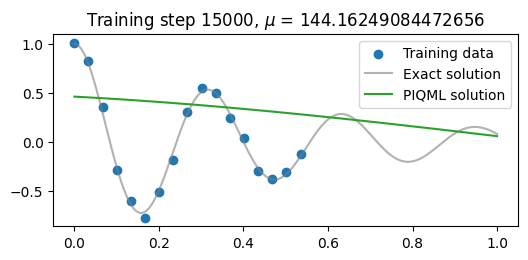


        Report on loss fns: 
        - Boundary Loss 1: 0.2910454571247101
        - Boundary Loss 2: 0.05236128345131874
        - Physical Loss 1: 6490.55908203125
        - MSE: 0.36482957005500793
        
[Parameter containing:
tensor([[[1.8635, 2.9315, 1.5980]],

        [[4.3434, 0.2997, 5.5640]],

        [[0.9782, 0.4558, 1.3341]],

        [[4.7420, 1.9202, 4.3367]],

        [[0.4947, 1.0190, 2.1938]]], requires_grad=True)]


In [14]:
for i in range(15000):
    optimiser.zero_grad()

    # Loss function for initial conditions
    prediction_initial = qmodel(t_initial_grad)
    loss1, loss2 = boundary_loss(prediction_initial, t_boundary=t_initial_grad)

    # Physics loss
    prediction_extend = qmodel(t_true_grad)
    loss3 = physics_loss(prediction_extend, t_physics=t_true_grad, mu=mu, k=k)

    # # Physics loss with dataset
    # loss3 = physics_loss(prediction, t_physics=t_data_grad, mu=mu, k=k)

    # Data loss
    prediction = qmodel(t_data_grad)
    loss4 = mseloss(prediction, obs_data)
    
    # Combined
    loss = lambda1*loss1 + lambda2*loss2 + lambda3*loss3 + lambda4*loss4
    
    if loss3 <= 10 and loss4 <= 0.002: break

    loss.backward()

    optimiser.step()

    # qmodel.quantum_layer.apply(clipper)

    all_mus.append(mu.item())
    all_loss.append(loss.item())

    if i % 1 == 0: 
        clear_output(wait=True)
        prediction = qmodel(t_true).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_data, obs_data, label="Training data")
        plt.plot(t_true[:,0], obs_true[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_true[:,0], prediction[:,0], label="PIQML solution", color="tab:green")
        plt.title(f"Training step {i+1}, $\mu$ = {mu.item()}")
        plt.legend()
        plt.savefig(f'./plots/PIQML_jacob_model/i_{i}.png', dpi=300)
        plt.show()
        
        print(f'''
        Report on loss fns: 
        - Boundary Loss 1: {loss1}
        - Boundary Loss 2: {loss2}
        - Physical Loss 1: {loss3}
        - MSE: {loss4}
        ''')
        print(list(qmodel.parameters())) # Uncomment this to see parameters updating


In [15]:
## MSE
np.mean((harmonic_oscillator_solution(d=2, w0=20, t=t_true) - qmodel(t_true)).detach().numpy())**2

0.07083461563981075

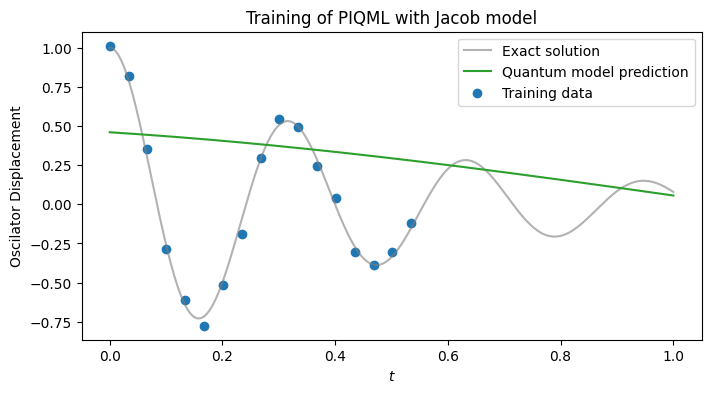

In [19]:
def plot_result(x,y,x_data,y_data,yh, title=None):

    plt.figure(figsize=(8,4))
    plt.title(title)
    plt.plot(x,y, color="tab:grey", alpha=0.6, label="Exact solution")
    plt.plot(x,yh, color="tab:green", label="Quantum model prediction")
    plt.scatter(x_data, y_data, label='Training data')
    plt.ylabel('Oscilator Displacement')
    plt.xlabel('$t$')
    l = plt.legend(loc='best')

plot_result(
    t_true.detach(),
    obs_true.detach(),
    t_data.detach(),
    obs_data.detach(),
    qmodel(t_true).detach(),
    title='Training of PIQML with Jacob model'
    )

mu = Parameter containing:
tensor([144.1625], requires_grad=True)


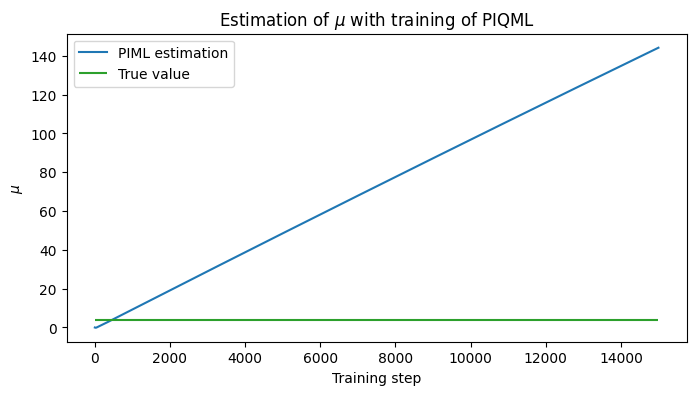

In [17]:
print(f'mu = {mu}')

plt.figure(figsize=(8,4))
plt.title("Estimation of $\mu$ with training of PIQML")
plt.plot(all_mus, label="PIML estimation")
plt.hlines(2*d, 0, len(all_mus), label="True value", color="tab:green")
plt.legend(loc='best')
plt.xlabel("Training step")
plt.ylabel("$\mu$")
plt.show()

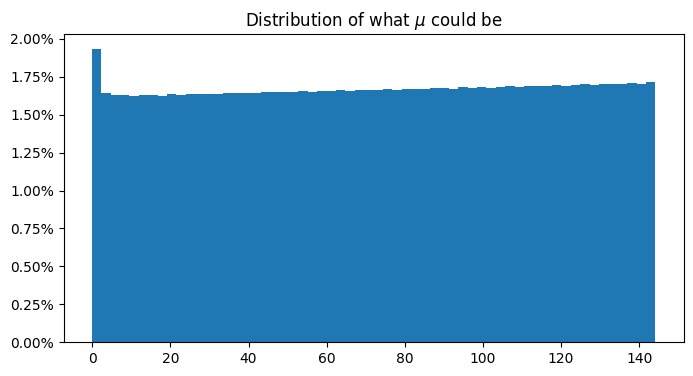

In [18]:
from matplotlib.ticker import PercentFormatter

plt.figure(figsize=(8,4))
plt.title('Distribution of what $\mu$ could be')
plt.hist(all_mus, bins=60, weights=np.ones(len(all_mus)) / len(all_mus))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()